# Session 4 - Model Selection and Regularization

### Contents

- [Subset Selection](#6.1-Subset-Selection)
- [Shrinkage Methods](#6.2-Shrinkage-Methods)
- [Principal Components Regression](#6.3-Principal-Components-Regression)
- [Partial Least Squares](#6.4-Partial-Least-Squares)

### Labs
- [Subset Selection methods](#6.5-Lab-1:-Subset-Selection-Methods)
- [Ridge Regression and the Lasso](#6.6-Lab-2:-Ridge-Regression-and-the-Lasso)
- [PCR and PLS Regression](#6.7-Lab-3:-PCR-and-PLS-Regression)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

In [1]:
# Import and setup matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
plt.style.use('seaborn-white')

## 6.1 Subset Selection

In [2]:
import pandas as pd

# Credit ratings dataset
credit = pd.read_csv('data/Credit.csv', usecols=list(range(1,12)))

In [3]:
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [4]:
# X and y
X = credit.loc[:, credit.columns != 'Balance']
y = credit.loc[:,'Balance']

In [6]:
import numpy as np
from itertools import combinations
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS

# Init RSS and R2
RSS = np.zeros((0,2))
R2 = np.zeros((0,2))

# Categorical variables 
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]

# Loop over all possible combinations of regressions
K = np.shape(X)[1]
for k in range(K+1):
    for i in combinations(range(K), k):
        
        # Subset X
        X_subset = X.iloc[:,list(i)]
        if k>0:
            cols = list(set(categ_cols) & set(X_subset.columns))
            X_subset = pd.get_dummies(X_subset, columns=cols, drop_first=True)

        # Regress
        reg = OLS(y,add_constant(X_subset)).fit()

        # Metrics
        r2 = np.reshape([k,reg.rsquared], (1,-1))
        R2 = np.append(R2, r2, axis=0)
        rss = np.reshape([k,reg.ssr], (1,-1))
        RSS = np.append(RSS, rss, axis=0)

In [7]:
# Save best scores
R2_best = [np.max(R2[R2[:,0]==k,1]) for k in range(K+1)]
RSS_best = [np.min(RSS[RSS[:,0]==k,1]) for k in range(K+1)]

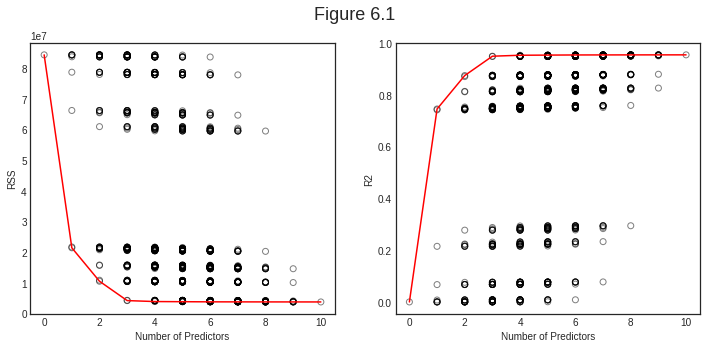

In [8]:
# Figure 6.1
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.1', fontsize=18)

# MSE
ax1.scatter(x=RSS[:,0], y=RSS[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1), RSS_best, c='r');
ax1.set_xlabel('Number of Predictors'); ax1.set_ylabel('RSS');

# R2
ax2.scatter(x=R2[:,0], y=R2[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), R2_best, c='r');
ax2.set_xlabel('Number of Predictors'); ax2.set_ylabel('R2');

In [9]:
# Init metrics
AIC = np.zeros((0,2))
BIC = np.zeros((0,2))
R2_adj = np.zeros((0,2))

# Loop over all possible combinations of regressions
for k in range(K+1):
    for i in combinations(range(K), k):
        
        # Subset X
        X_subset = X.iloc[:,list(i)]
        if k>0:
            cols = list(set(categ_cols) & set(X_subset.columns))
            X_subset = pd.get_dummies(X_subset, columns=cols, drop_first=True)

        # Regress
        reg = OLS(y,add_constant(X_subset)).fit()

        # Advanced Metrics
        aic = np.reshape([k,reg.aic], (1,-1))
        AIC = np.append(AIC, aic, axis=0)
        bic = np.reshape([k,reg.bic], (1,-1))
        BIC = np.append(BIC, bic, axis=0)
        r2_adj = np.reshape([k,reg.rsquared_adj], (1,-1))
        R2_adj = np.append(R2_adj, r2_adj, axis=0)

In [10]:
# Save best scores
AIC_best = [np.min(AIC[AIC[:,0]==k,1]) for k in range(K+1)]
BIC_best = [np.min(BIC[BIC[:,0]==k,1]) for k in range(K+1)]
R2_adj_best = [np.max(R2_adj[R2_adj[:,0]==k,1]) for k in range(K+1)]

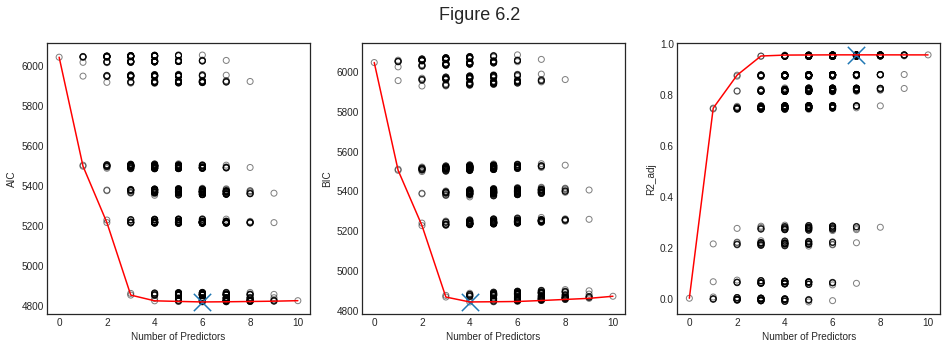

In [11]:
# Figure 6.2
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Figure 6.2', fontsize=18)

# AIC
ax1.scatter(x=AIC[:,0], y=AIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1),AIC_best, c='r');
ax1.scatter(np.argmin(AIC_best), np.min(AIC_best), marker='x', s=300)
ax1.set_xlabel('Number of Predictors'); ax1.set_ylabel('AIC');

# BIC
ax2.scatter(x=BIC[:,0], y=BIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), BIC_best, c='r');
ax2.scatter(np.argmin(BIC_best), np.min(BIC_best), marker='x', s=300)
ax2.set_xlabel('Number of Predictors'); ax2.set_ylabel('BIC');

# R2 adj
ax3.scatter(x=R2_adj[:,0], y=R2_adj[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax3.plot(range(K+1), R2_adj_best, c='r');
ax3.scatter(np.argmax(R2_adj_best), np.max(R2_adj_best), marker='x', s=300)
ax3.set_xlabel('Number of Predictors'); ax3.set_ylabel('R2_adj');

## 6.2 Shrinkage Methods

### 6.2.1 Ridge Regression

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:

$$ 
\frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) 
$$

(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to

$$ 
\frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 
$$
    
The __sklearn Ridge()__ function optimizes:

$$ 
||X\beta - y||^2_2 + \alpha ||\beta||^2_2 
$$

which is equivalent to optimizing

$$ 
\frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 
$$

In [12]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

In [15]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale 

# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(-2,5,n_grid).reshape(-1,1)
ridge = Ridge()
coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [16]:
from sklearn.linear_model import LinearRegression

# OLS regression
reg = LinearRegression().fit(scale(X),y)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

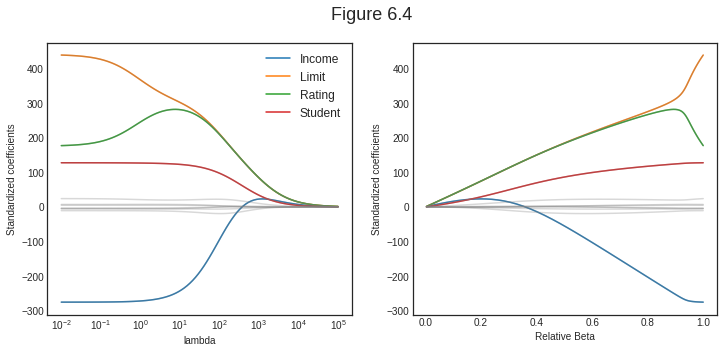

In [17]:
# Figure 6.4
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.4', fontsize=18)

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax1.plot(alphas, coefs[:,highlight], alpha=1)
ax1.plot(alphas, coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

# Plot coefficients - relative
ax2.plot(rel_beta, coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, coefs, c='grey', alpha=0.3)
ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Standardized coefficients');


The above plot shows that the Ridge coefficients get larger when we decrease alpha.

In [18]:
from numpy.random import normal as rnorm
np.random.seed(3)

# Generate random data
n = 50
k = 45
k0 = k
X_train = rnorm(0,1,(n,k))
e_train = rnorm(0,k0**0.5,(n,1))
b0 = rnorm(0,1,(k0,1))

# y only depends on the first two columns
y_train = X_train[:,0:k0] @ b0 + e_train

# Test
X_test = rnorm(0,1,(n,k))
e_test = rnorm(0,k0**0.5,(n,1))
f_test = X_test[:,0:k0] @ b0
y_test = f_test + e_test

In [19]:
# Init alpha grid
n_grid = 100
df = pd.DataFrame({'alpha':10**np.linspace(-2,5,n_grid)})
coefs = []

# Loop over values of alpha
for i in range(len(df)):
    a = df.loc[i,'alpha']
    ridge = Ridge(alpha=a).fit(scale(X_train), y_train)
    y_hat = ridge.predict(scale(X_test))
    df.loc[i,'var'] = np.var(y_hat)
    df.loc[i,'mse'] = np.mean((y_test - y_hat)**2)
    df.loc[i,'bias2'] = df.loc[i,'mse'] - df.loc[i,'var'] - np.var(e_test)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [20]:
# OLS regression
reg = LinearRegression().fit(scale(X_train),y_train)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

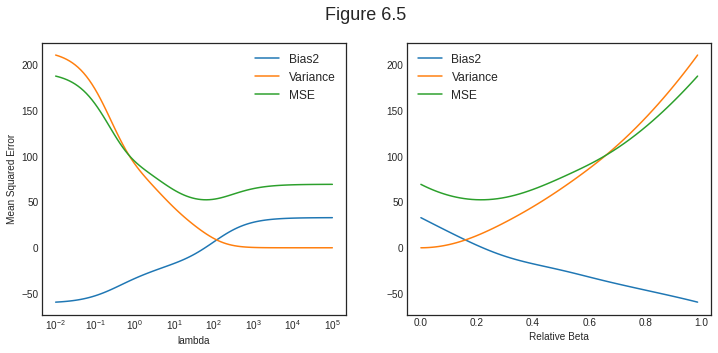

In [21]:
# Figure 6.4
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.5', fontsize=18)

# MSE
ax1.plot(df['alpha'], df[['bias2','var','mse']]);
ax1.set_xscale('log');
ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

# MSE
ax2.plot(rel_beta, df[['bias2','var','mse']]);
ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

### 6.2.2 Lasso

In [22]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

In [25]:
from sklearn.linear_model import Lasso

# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(0,3,n_grid).reshape(-1,1)
lasso = Lasso()
coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [26]:
# OLS regression
reg = LinearRegression().fit(scale(X),y)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

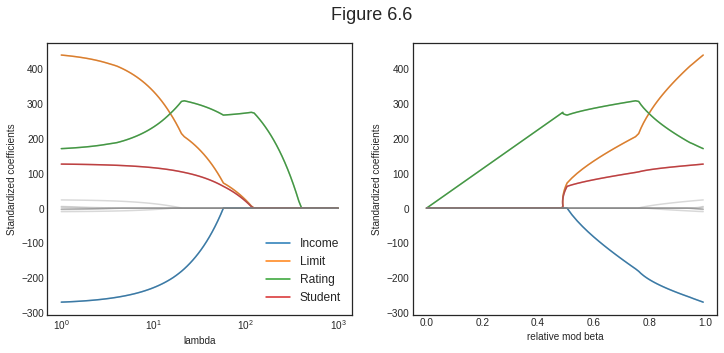

In [27]:
# Figure 6.6
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.6', fontsize=18)

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax1.plot(alphas, coefs[:,highlight], alpha=1)
ax1.plot(alphas, coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

# Plot coefficients - relative
ax2.plot(rel_beta, coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, coefs, c='grey', alpha=0.3)
ax2.set_xlabel('relative mod beta'); ax2.set_ylabel('Standardized coefficients');


In [28]:
# Init alpha grid
n_grid = 100
df = pd.DataFrame({'alpha':10**np.linspace(-1,1,n_grid)})
coefs = []

# Loop over values of alpha
for i in range(len(df)):
    a = df.loc[i,'alpha']
    lasso = Lasso(alpha=a).fit(scale(X_train), y_train)
    y_hat = lasso.predict(scale(X_test))
    df.loc[i,'var'] = np.var(y_hat)
    df.loc[i,'mse'] = np.mean((y_test - y_hat)**2)
    df.loc[i,'bias2'] = np.mean((y_hat - f_test)**2)
    df.loc[i,'bias2'] = df.loc[i,'mse'] - df.loc[i,'var'] - np.var(e_test)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [29]:
# OLS regression
ols_reg = LinearRegression().fit(scale(X_train),y_train)
ols_coefs = ols_reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

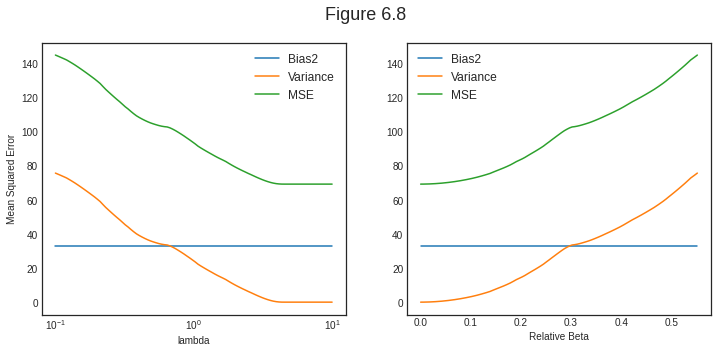

In [30]:
# Figure 6.8
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.8', fontsize=18)

# MSE
ax1.plot(df['alpha'], df[['bias2','var','mse']]);
ax1.set_xscale('log');
ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

# MSE
ax2.plot(rel_beta, df[['bias2','var','mse']]);
ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

In [31]:
from numpy.random import uniform as runi
np.random.seed(3)

# Generate random data
n = 100
k = n
X = np.eye(k)
e = rnorm(0,1,(n,1))
b0 = runi(-1,1,(k,1))
y = X @ b0 + e

In [32]:
# OLS regression
reg = LinearRegression().fit(X,y)
ols_coefs = reg.coef_;

# Ridge regression
ridge = Ridge(alpha=1).fit(X,y)
ridge_coefs = ridge.coef_;

# Ridge regression
lasso = Lasso(alpha=0.01).fit(X,y)
lasso_coefs = lasso.coef_.reshape(1,-1);

# sort
order = np.argsort(y.reshape(1,-1), axis=1)
y_sorted = np.take_along_axis(ols_coefs, order, axis=1) 
ols_coefs = np.take_along_axis(ols_coefs, order, axis=1) 
ridge_coefs = np.take_along_axis(ridge_coefs, order, axis=1) 
lasso_coefs = np.take_along_axis(lasso_coefs, order, axis=1) 

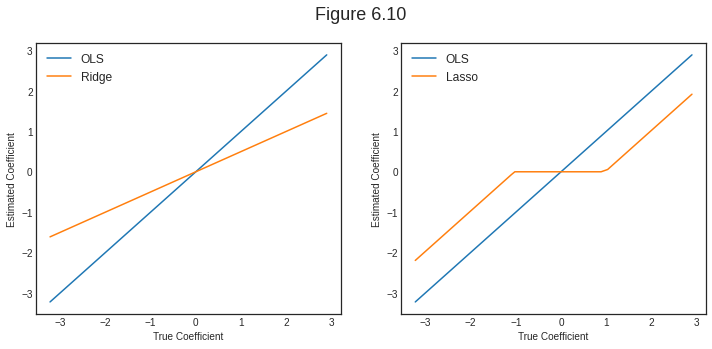

In [33]:
# Figure 6.10
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.10', fontsize=18)

# Ridge
ax1.plot(y_sorted.T, ols_coefs.T)
ax1.plot(y_sorted.T, ridge_coefs.T)
ax1.set_xlabel('True Coefficient'); ax1.set_ylabel('Estimated Coefficient');
ax1.legend(['OLS','Ridge'], fontsize=12);

# Lasso
ax2.plot(y_sorted.T, ols_coefs.T)
ax2.plot(y_sorted.T, lasso_coefs.T)
ax2.set_xlabel('True Coefficient'); ax2.set_ylabel('Estimated Coefficient');
ax2.legend(['OLS','Lasso'], fontsize=12);

### 6.2.3 Selecting the Tuning Parameter

In [34]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True).values
y = credit.loc[:,'Balance']
n = len(credit)

In [35]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Get Mse Function
def cv_ridge(X,y,a):
    mse = []
    # Generate splits
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    # Loop over splits
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ridge = Ridge(alpha=a).fit(X_train, y_train)
        y_hat = ridge.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    return np.mean(mse)

In [39]:
# Compute MSE over grid of alphas
# WARNING! takes time
n_grid = 30
alphas = 10**np.linspace(-3,1,n_grid).reshape(-1,1)
MSE = [cv_ridge(X,y,a) for a in alphas]

In [40]:
# Find minimum alpha
alpha_min = alphas[np.argmin(MSE)]
print('Best alpha by LOO CV:',alpha_min[0])

Best alpha by LOO CV: 0.16102620275609392


In [41]:
# Get coefficients
coefs = []

# Loop over values of alpha
for a in alphas:
    ridge = Ridge(alpha=a).fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

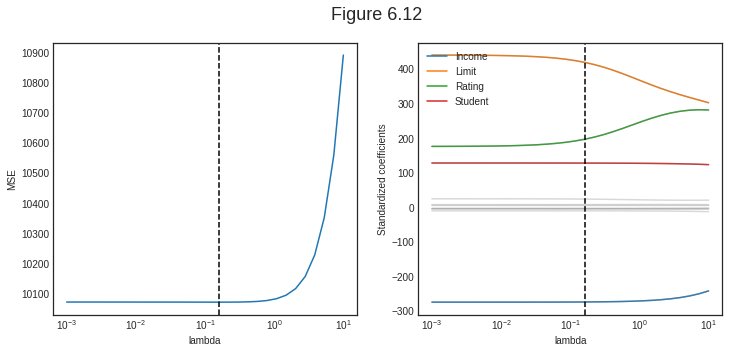

In [45]:
# Figure 6.12
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.12', fontsize=18)

# MSE by LOO CV
ax1.plot(alphas, MSE, alpha=1);
ax1.axvline(alpha_min, c='k', ls='--')
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('MSE');

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax2.plot(alphas, coefs[:,highlight], alpha=1)
ax2.plot(alphas, coefs, c='grey', alpha=0.3)
ax2.axvline(alpha_min, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel('lambda'); ax2.set_ylabel('Standardized coefficients');
ax2.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=10);


# Labs

In [135]:
## 6.5 Lab 1: Subset Selection Methods

## 6.5.1 Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [139]:
hitters_df = pd.read_csv('data/Hitters.csv')
hitters_df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the `Salary` variable is missing for some of the
players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` value
for any elements that are missing, and a `FALSE` value for non-missing elements.
The `sum()` function can then be used to count all of the missing elements:

In [140]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


We see that `Salary` is missing for 59 players. The `dropna()` function
removes all of the rows that have missing values in any variable:

In [141]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna().iloc[:,1:]

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 20)
Number of null values: 0


In [142]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [143]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [144]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [147]:
import time
import itertools

# Could take quite awhile to complete...
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.03105449676513672 seconds.
Processed 171 models on 2 predictors in 0.2609522342681885 seconds.
Processed 969 models on 3 predictors in 1.4286644458770752 seconds.
Processed 3876 models on 4 predictors in 6.013415098190308 seconds.
Processed 11628 models on 5 predictors in 18.682019233703613 seconds.
Processed 27132 models on 6 predictors in 42.81816220283508 seconds.
Processed 50388 models on 7 predictors in 81.10738468170166 seconds.
Total elapsed time: 150.6867983341217 seconds.


Now we have one big `DataFrame` that contains the best models we've generated along with their RSS:

In [ ]:
models_best

If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [ ]:
print(models_best.loc[2, "model"].summary())

This output indicates that the best two-variable model
contains only `Hits` and `CRBI`. To save time, we only generated results
up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [ ]:
# Show the best 19-variable model (there's actually only one)
print(getBest(19)["model"].summary())

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [ ]:
models_best.loc[2, "model"].rsquared

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [ ]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the `type="l"` option tells `R` to
connect the plotted points with lines:

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

# 6.5.2 Forward and Backward Stepwise Selection
We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

In [ ]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now let's see how much faster it runs!

In [ ]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Phew! That's a lot better. Let's take a look:

In [ ]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

We see that using forward stepwise selection, the best one-variable
model contains only `Hits`, and the best two-variable model additionally
includes `CRBI`. Let's see how the models stack up against best subset selection:

In [ ]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.

# Backward Selection
Not much has to change to implement backward selection... just looping through the predictors in reverse!

In [ ]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection,
backward stepwise selection, and best subset selection are different:

In [ ]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

In [ ]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

In [ ]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

# Getting credit
To get credit for this lab, please post an example where you would choose to use each of the following:
- Best subset
- Forward selection
- Backward selection

to [Moodle](https://moodle.smith.edu/mod/quiz/view.php?id=257886).

## 6.6 Lab 2: Ridge Regression and the Lasso

In [63]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df = pd.read_csv('data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [64]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [65]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0    

In [66]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8

In [67]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [68]:
X_train = pd.read_csv('data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('data/Hitters_y_test.csv', index_col=0)

### 6.6.1 - Ridge Regression

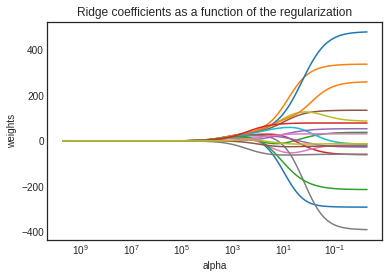

In [69]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [71]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

193147.46143016344

In [72]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          0.015146
Hits           0.016050
HmRun          0.013561
Runs           0.015681
RBI            0.016782
Walks          0.019662
Years          0.010390
CAtBat         0.016570
CHits          0.017627
CHmRun         0.015072
CRuns          0.018771
CRBI           0.016697
CWalks         0.016821
PutOuts        0.003228
Assists       -0.007600
Errors         0.013672
League_N       0.003519
Division_W     0.003339
NewLeague_N    0.003499
dtype: float64

#### Alpha = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [73]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

193253.09741651407

#### Compute the regularization path using RidgeCV

In [79]:
from sklearn.linear_model import RidgeCV

# Use cross-validated Ridge regression
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        scoring='neg_mean_squared_error')

In [80]:
ridgecv.alpha_

115.5064850041579

In [81]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))

97384.9295917259

In [82]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

### python-glmnet (update 2016-08-29)
This relatively new module is a wrapper for the fortran library used in the R package `glmnet`. It gives mostly the exact same results as described in the book. However, the `predict()` method does not give you the regression *coefficients* for lambda values not in the lambda_path. It only returns the predicted values.
https://github.com/civisanalytics/python-glmnet

In [83]:
import glmnet as gln

# Set grid
grid = 10**np.linspace(10,-2,100)

ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(X, y)

ElasticNet(alpha=0,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]))

#### Lambda 11498

In [84]:
ridge3.lambda_path_[49]

11497.569953977356

In [85]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[49]))

Intercept: 407.356


In [86]:
pd.Series(np.round(ridge3.coef_path_[:,49], decimals=3), index=X.columns)

AtBat          0.037
Hits           0.138
HmRun          0.525
Runs           0.231
RBI            0.240
Walks          0.290
Years          1.108
CAtBat         0.003
CHits          0.012
CHmRun         0.088
CRuns          0.023
CRBI           0.024
CWalks         0.025
PutOuts        0.016
Assists        0.003
Errors        -0.021
League_N       0.085
Division_W    -6.215
NewLeague_N    0.301
dtype: float64

In [87]:
np.sqrt(np.sum(ridge3.coef_path_[:,49]**2))

6.3606122865384505

#### Lambda 705

In [88]:
ridge3.lambda_path_[59]

705.4802310718645

In [89]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[59]))

Intercept: 54.325


In [90]:
pd.Series(np.round(ridge3.coef_path_[:,59], decimals=3), index=X.columns)

AtBat           0.112
Hits            0.656
HmRun           1.180
Runs            0.938
RBI             0.847
Walks           1.320
Years           2.596
CAtBat          0.011
CHits           0.047
CHmRun          0.338
CRuns           0.094
CRBI            0.098
CWalks          0.072
PutOuts         0.119
Assists         0.016
Errors         -0.704
League_N       13.684
Division_W    -54.659
NewLeague_N     8.612
dtype: float64

In [91]:
np.sqrt(np.sum(ridge3.coef_path_[:,59]**2))

57.11003436702412

#### Fit model using just the training set.

In [92]:
ridge4 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge4.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=0,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           scoring='mean_squared_error', tol=1e-12)

In [93]:
# prediction using lambda = 4
pred = ridge4.predict(X_test, lamb=4)
mean_squared_error(y_test.values.ravel(), pred)

101036.832308929

#### Lambda chosen by cross validation

In [94]:
ridge5 = gln.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge5.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=0, scoring='mean_squared_error')

In [95]:
# Lambda with best CV performance
ridge5.lambda_max_

307.2007848050221

In [96]:
# Lambda larger than lambda_max_, but with a CV score that is within 1 standard deviation away from lambda_max_ 
ridge5.lambda_best_

array([20211.76029641])

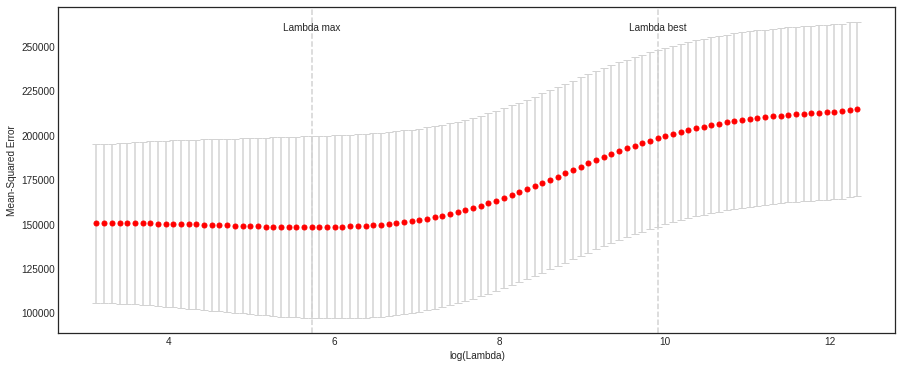

In [97]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [98]:
# MSE for lambda with best CV performance
pred = ridge5.predict(X_test, lamb=ridge5.lambda_max_)
mean_squared_error(y_test, pred)

96174.51562389842

#### Fit model to full data set

In [99]:
ridge6= gln.ElasticNet(alpha=0, scoring='mean_squared_error', n_splits=10)
ridge6.fit(X, y)

ElasticNet(alpha=0, n_splits=10, scoring='mean_squared_error')

In [100]:
# These are not really close to the ones in the book.
pd.Series(ridge6.coef_path_[:,ridge6.lambda_max_inx_], index=X.columns)

AtBat           -0.681594
Hits             2.772311
HmRun           -1.365704
Runs             1.014812
RBI              0.713030
Walks            3.378558
Years           -9.066826
CAtBat          -0.001200
CHits            0.136102
CHmRun           0.697992
CRuns            0.295890
CRBI             0.257072
CWalks          -0.278966
PutOuts          0.263887
Assists          0.169878
Errors          -3.685656
League_N        53.209503
Division_W    -122.834334
NewLeague_N    -18.102528
dtype: float64

### 6.6.2 The Lasso

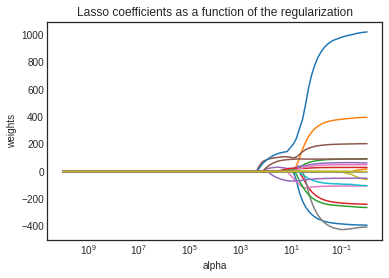

In [101]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [104]:
from sklearn.linear_model import LassoCV

lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

LassoCV(cv=10, max_iter=10000)

In [105]:
lassocv.alpha_

30.01382256446427

In [106]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696965

In [107]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

### python-glmnet

In [108]:
lasso2 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso2.fit(X_train, y_train.values.ravel())

ElasticNet(lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.848...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           n_splits=10, scoring='mean_squared_error')

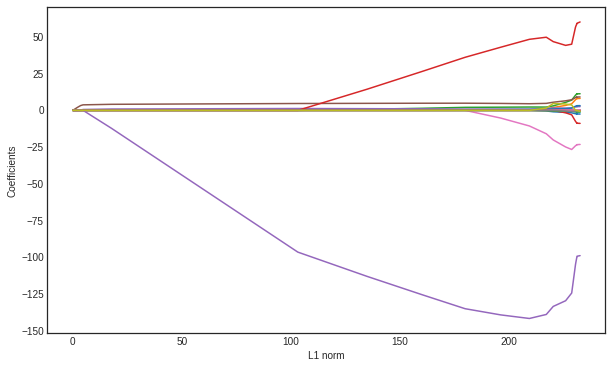

In [109]:
l1_norm = np.sum(np.abs(lasso2.coef_path_), axis=0)

plt.figure(figsize=(10,6))
plt.plot(l1_norm, lasso2.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

#### Let glmnet() create a grid to use in CV

In [110]:
lasso3 = gln.ElasticNet(alpha=1, scoring='mean_squared_error', n_splits=10)
lasso3.fit(X_train, y_train.values.ravel())

ElasticNet(n_splits=10, scoring='mean_squared_error')

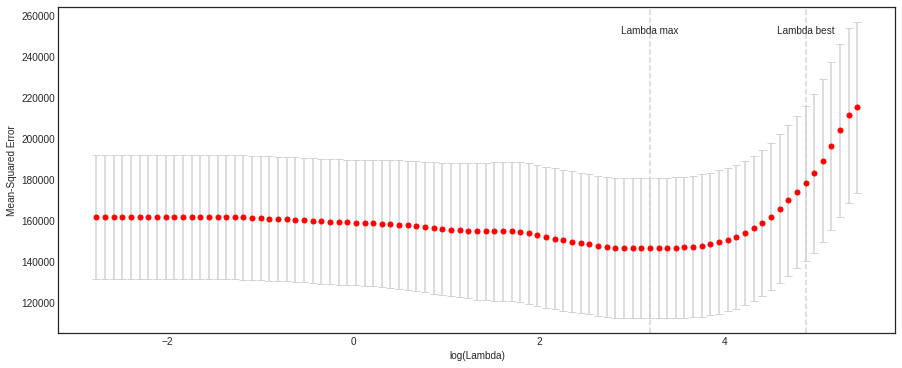

In [111]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(lasso3.lambda_path_), -lasso3.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=lasso3.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([lasso3.lambda_best_, lasso3.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [112]:
pred = lasso3.predict(X_test, lamb=lasso3.lambda_max_)
mean_squared_error(y_test, pred)

101108.47727555902

#### Fit model on full dataset

In [113]:
lasso4 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso4.fit(X, y)

ElasticNet(lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.848...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           n_splits=10, scoring='mean_squared_error')

In [114]:
# These are not really close to the ones in the book.
pd.Series(lasso4.coef_path_[:,lasso4.lambda_max_inx_], index=X.columns)

AtBat           -1.560098
Hits             5.693168
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks            4.750540
Years           -9.518024
CAtBat           0.000000
CHits            0.000000
CHmRun           0.519161
CRuns            0.660407
CRBI             0.391541
CWalks          -0.532687
PutOuts          0.272620
Assists          0.174816
Errors          -2.056721
League_N        32.109569
Division_W    -119.258342
NewLeague_N      0.000000
dtype: float64

## 6.7 Lab 3: PCR and PLS Regression

### 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [117]:
from sklearn.decomposition import PCA

pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


The above loadings are the same as in R.

In [118]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


The above principal components are the same as in R.

In [119]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

In [125]:
from sklearn.model_selection import KFold, cross_val_score

# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
 

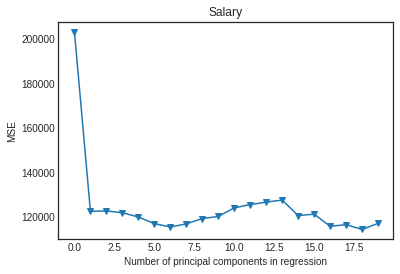

In [126]:
# Plot   
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 18 components.

In [127]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,  -21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,   20.99269291,
         72.40210574, -276.68551696,  -74.17098665,  422.72580227,
       -347.05662353, -561.59691587,  -83.25441536])

#### Fitting PCA with training data

/home/mcourt/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


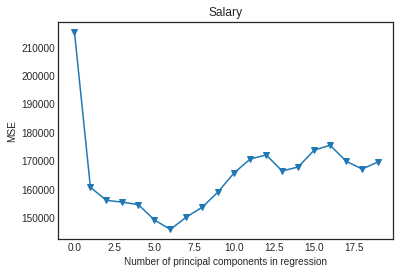

In [128]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### Transform test data with PCA loadings and fit regression on 6 principal components

In [129]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

96320.02078250323

### 6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'. 

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

    pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
    validationplot(pls.fit,val.type="MSEP", intercept = FALSE)
   
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

In [132]:
from sklearn.cross_decomposition import PLSRegression

n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

/home/mcourt/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


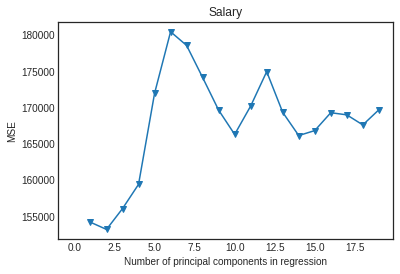

In [133]:
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [134]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

102234.27995999217

## Next Lecture

Jump to [Session 6 - Convexity and optimization](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/6_convexity.ipynb)